In [1]:
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")

# Data Loading

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load a DataFrame with a specific version of a CSV
df: pd.DataFrame = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "shiveshprakash/34-year-daily-stock-data/versions/1",
    "stock_data.csv",
)

# Drop useless columns or which we will create ourselves
df = df.drop(columns=["prev_day"])

# Display the first few rows of the dataframe
df.head()

,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD
0,1990-01-03,18.19,358.760010,192330000.0,2809.73,23.62,2858.699951,-0.229917,7.89,3,100.359178,75.408051
1,1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,100.359178,56.085804
2,1990-01-05,20.11,352.200012,158530000.0,2773.25,20.29,2839.899902,-0.260393,7.79,3,100.359178,63.847675
3,1990-01-08,20.26,353.790009,140110000.0,2794.37,16.61,2816.000000,-0.291750,7.79,3,100.359178,102.841156
4,1990-01-09,22.20,349.619995,155210000.0,2766.00,15.80,2822.000000,-0.297326,7.80,3,100.359178,138.435669


# Data Cleaning and Preprocessing

In [3]:
# Check for missing values
df.isnull().sum()

dt              0
vix             0
sp500           0
sp500_volume    0
djia            0
djia_volume     0
hsi             0
ads             0
us3m            0
joblessness     0
epu             0
GPRD            0
dtype: int64

In [4]:
# Convert "dt" to datetime format
df["dt"] = pd.to_datetime(df["dt"], format="%Y-%m-%d")

# Check data types
df.dtypes

dt              datetime64[ns]
vix                    float64
sp500                  float64
sp500_volume           float64
djia                   float64
djia_volume            float64
hsi                    float64
ads                    float64
us3m                   float64
joblessness              int64
epu                    float64
GPRD                   float64
dtype: object

# Data Analysis

### General Plots

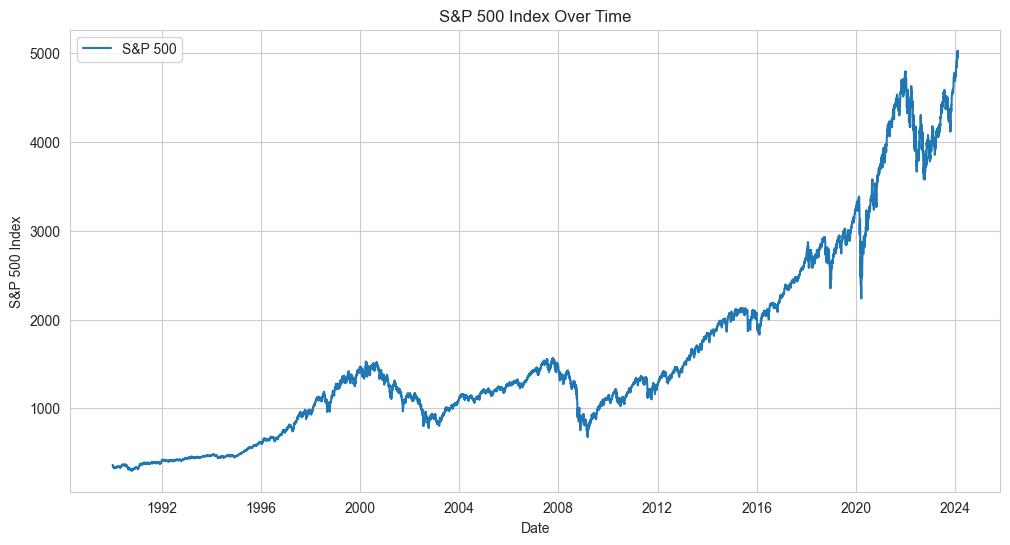

In [5]:
# Plot the S&P 500 over time
plt.figure(figsize=(12, 6))
sns.lineplot(x=df["dt"], y=df["sp500"], label="S&P 500")
plt.title("S&P 500 Index Over Time")
plt.xlabel("Date")
plt.ylabel("S&P 500 Index")
plt.legend()
plt.show()

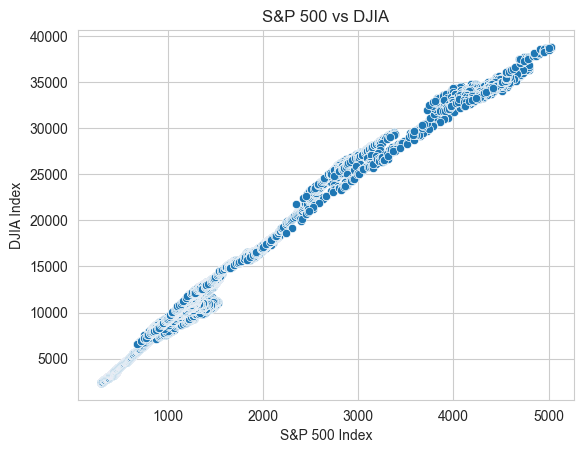

In [6]:
# Visualize the relationship between S&P 500 and DJIA
sns.scatterplot(x="sp500", y="djia", data=df)
plt.title("S&P 500 vs DJIA")
plt.xlabel("S&P 500 Index")
plt.ylabel("DJIA Index")
plt.show()

### Correlation Analysis

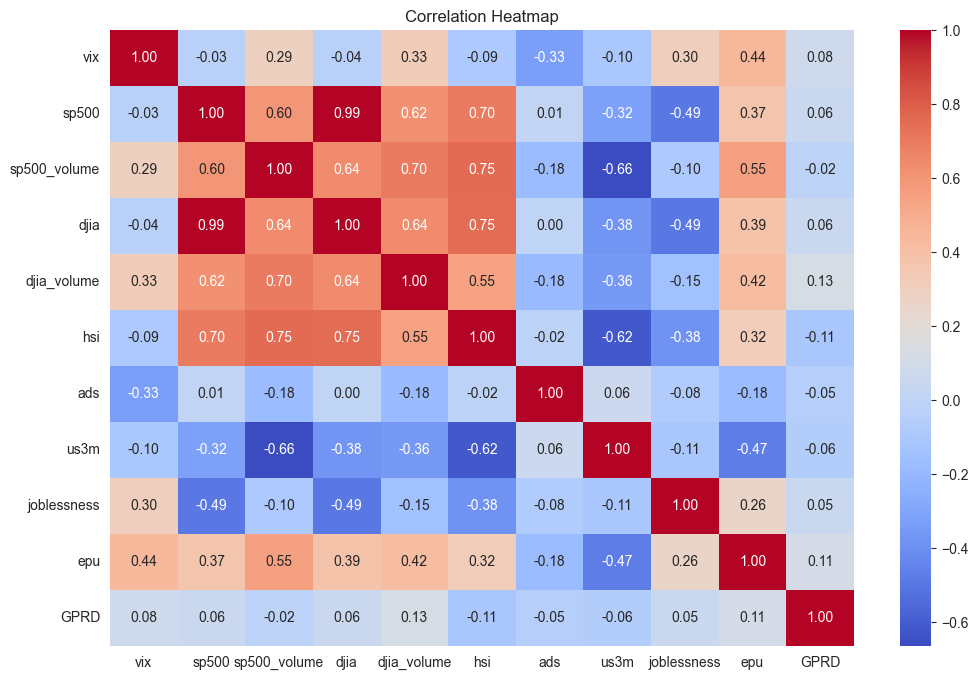

In [7]:
# Select only numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Create new features

### Aggregate Rolling Features

In [8]:
windows = [7, 14, 30, 90, 365]  # Rolling window sizes (days)

cols_to_aggregate = ["sp500", "sp500_volume", "djia", "djia_volume", "hsi", "vix"]
less_correlated_features = ["us3m", "joblessness", "epu"]
cols_to_aggregate_all = cols_to_aggregate + less_correlated_features
nr_window_features = 0
for window in windows:
    for col in cols_to_aggregate_all:
        df[f"{col}_mean_{window}"] = df[col].rolling(window=window, min_periods=1).mean()
        df[f"{col}_std_{window}"] = df[col].rolling(window=window, min_periods=1).std()
        nr_window_features += 2

# Drop rows with NaN values introduced by rolling calculations
df = df.dropna()

print(f"Nr of window features: {nr_window_features}")

# Display the updated DataFrame
df.head()

Nr of window features: 90


,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,...,hsi_mean_365,hsi_std_365,vix_mean_365,vix_std_365,us3m_mean_365,us3m_std_365,joblessness_mean_365,joblessness_std_365,epu_mean_365,epu_std_365
1,1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,...,2863.349976,6.576128,18.705000,0.728320,7.8650,0.035355,3.0,0.0,100.359178,0.0
2,1990-01-05,20.11,352.200012,158530000.0,2773.25,20.29,2839.899902,-0.260393,7.79,3,...,2855.533284,14.315192,19.173333,0.960850,7.8400,0.050000,3.0,0.0,100.359178,0.0
3,1990-01-08,20.26,353.790009,140110000.0,2794.37,16.61,2816.000000,-0.291750,7.79,3,...,2845.649963,22.963811,19.445000,0.954306,7.8275,0.047871,3.0,0.0,100.359178,0.0
4,1990-01-09,22.20,349.619995,155210000.0,2766.00,15.80,2822.000000,-0.297326,7.80,3,...,2840.919971,22.524800,19.996000,1.483587,7.8220,0.043243,3.0,0.0,100.359178,0.0
5,1990-01-10,22.44,347.309998,175990000.0,2750.64,19.95,2868.000000,-0.300341,7.75,3,...,2845.433309,22.980745,20.403333,1.660225,7.8100,0.048580,3.0,0.0,100.359178,0.0


### Autoencoders

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Create lagged features (temporary DataFrame)
lag_days = 365
lagged_df = pd.DataFrame()
# for lag in range(1, lag_days + 1):
# lagged_df[f"sp500_lag_{lag}"] = df["sp500"].shift(lag)
# lagged_df[f"sp500_volume_lag_{lag}"] = df["sp500_volume"].shift(lag)
# lagged_df[f"djia_lag_{lag}"] = df["djia"].shift(lag)
# lagged_df[f"djia_volume_lag_{lag}"] = df["djia_volume"].shift(lag)
# lagged_df[f"hsi_lag_{lag}"] = df["hsi"].shift(lag)
# lagged_df[f"vix_lag_{lag}"] = df["vix"].shift(lag)

for col in cols_to_aggregate:
    for lag in range(1, lag_days + 1):
        lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
for col in less_correlated_features:
    for lag in [7, 14, 30, 90]:
        lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)

# Drop rows with NaN values
lagged_df = lagged_df.dropna()

# Normalize lagged features
scaler = MinMaxScaler()
X_lagged = scaler.fit_transform(lagged_df.values)
joblib.dump(scaler, "lagged_scaler.pkl")  # Save the scaler

# Clean up: Delete the temporary lagged features DataFrame
del lagged_df

# Get input dimensions
input_dim = X_lagged.shape[1]  # Number of lagged features

# Display the number of lagged features
print(f"Nr of lagged features: {input_dim}")

Nr of lagged features: 2202


In [ ]:
import optuna
from backend.autoencoders import objective

# Number of trials for optimization
n_trials = 100

# Run Optuna optimization
study_ae = optuna.create_study(direction="minimize")
study_ae.optimize(lambda trial: objective(trial, X_lagged), n_trials=n_trials)

In [ ]:
# Print best hyperparameters
print("\nBest Autoencoder Parameters:")
print(study_ae.best_params)

In [11]:
from backend.autoencoders import Autoencoder, train_predict_autoencoder

# Get best parameters
best_params = study_ae.best_params

# Initialize Autoencoder with best parameters
autoencoder = Autoencoder(
    input_dim=X_lagged.shape[1],
    encoding_dim=best_params["encoding_dim"],
    hidden_dim=best_params["hidden_dim"],
    dropout_rate=best_params["dropout_rate"],
)

# Train Autoencoder
trained_autoencoder, embeddings, last_mse_loss = train_predict_autoencoder(
    autoencoder,
    X_lagged,
    epochs=200,
    batch_size=best_params["batch_size"],
    lr=best_params["lr"],
    l1_penalty=best_params["l1_penalty"],
    weight_decay=best_params["weight_decay"],
)

Epoch 1/200, Avg Loss: 0.1175, Best Loss: 0.1175 at Epoch 1
Epoch 2/200, Avg Loss: 0.0481, Best Loss: 0.0481 at Epoch 2
Epoch 3/200, Avg Loss: 0.0310, Best Loss: 0.0310 at Epoch 3
Epoch 4/200, Avg Loss: 0.0306, Best Loss: 0.0306 at Epoch 4
Epoch 5/200, Avg Loss: 0.0285, Best Loss: 0.0285 at Epoch 5
Epoch 6/200, Avg Loss: 0.0241, Best Loss: 0.0241 at Epoch 6
Epoch 7/200, Avg Loss: 0.0243, Best Loss: 0.0241 at Epoch 6
Epoch 8/200, Avg Loss: 0.0243, Best Loss: 0.0241 at Epoch 6
Epoch 9/200, Avg Loss: 0.0233, Best Loss: 0.0233 at Epoch 9
Epoch 10/200, Avg Loss: 0.0244, Best Loss: 0.0233 at Epoch 9
Epoch 11/200, Avg Loss: 0.0210, Best Loss: 0.0210 at Epoch 11
Epoch 12/200, Avg Loss: 0.0210, Best Loss: 0.0210 at Epoch 11
Epoch 13/200, Avg Loss: 0.0185, Best Loss: 0.0185 at Epoch 13
Epoch 14/200, Avg Loss: 0.0197, Best Loss: 0.0185 at Epoch 13
Epoch 15/200, Avg Loss: 0.0185, Best Loss: 0.0185 at Epoch 15
Epoch 16/200, Avg Loss: 0.0170, Best Loss: 0.0170 at Epoch 16
Epoch 17/200, Avg Loss: 0.0

In [12]:
# Convert embeddings to DataFrame
embedding_df = pd.DataFrame(embeddings, columns=[f"embed_{i + 1}" for i in range(embeddings.shape[1])])

### Prepare the final df to train

##### Take the right data for training

In [13]:
# Select only numeric columns for training
training_df = df.select_dtypes(include=[np.number])

# Convert to an ordered categorical column
if training_df["joblessness"].dtypes != "category":
    training_df["joblessness"] = pd.Categorical(
        training_df["joblessness"],
        categories=[1, 2, 3, 4],
        ordered=True
    )

##### Scale the df

In [14]:
# Separate the "joblessness" column
joblessness = training_df["joblessness"]

# Select all columns except "joblessness"
columns_to_scale = training_df.drop(columns=["joblessness"]).columns

# Apply MinMaxScaler to the selected columns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(training_df[columns_to_scale])
joblib.dump(scaler, "training_df_scaler.pkl")  # Save the scaler

# Create a DataFrame for the scaled data
training_df = pd.DataFrame(scaled_data, columns=columns_to_scale, index=training_df.index)

# Add back the "joblessness" column
training_df["joblessness"] = joblessness

##### Attach embeddings to the training DataFrame

In [15]:
# Attach embeddings to the main DataFrame
training_df = pd.concat([training_df.reset_index(drop=True), embedding_df], axis=1)

# Display the final DataFrame with embeddings
training_df.head()

,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,epu,GPRD,...,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20,embed_21,embed_22,embed_23,embed_24
0,0.137050,0.012718,0.014160,0.011829,0.024732,0.004320,0.729023,0.949153,0.147163,0.044970,...,0.00061,-0.010819,-0.005904,0.011715,0.008208,-0.006489,-0.000626,-0.008564,-0.000264,0.001441
1,0.149150,0.011985,0.012546,0.011203,0.020302,0.003396,0.728624,0.943099,0.147163,0.052462,...,0.00061,-0.010819,-0.005904,0.011715,0.008208,-0.006489,-0.000626,-0.008564,-0.000264,0.001441
2,0.151190,0.012321,0.010936,0.011783,0.016307,0.002610,0.727750,0.943099,0.147163,0.090096,...,0.00061,-0.010819,-0.005904,0.011715,0.008208,-0.006489,-0.000626,-0.008564,-0.000264,0.001441
3,0.177566,0.011440,0.012256,0.011004,0.015427,0.002808,0.727595,0.944310,0.147163,0.124450,...,0.00061,-0.010819,-0.005904,0.011715,0.008208,-0.006489,-0.000626,-0.008564,-0.000264,0.001441
4,0.180829,0.010952,0.014072,0.010582,0.019933,0.004320,0.727511,0.938257,0.147163,0.090749,...,0.00061,-0.010819,-0.005904,0.011715,0.008208,-0.006489,-0.000626,-0.008564,-0.000264,0.001441


In [16]:
print(list(training_df.columns))

['vix', 'sp500', 'sp500_volume', 'djia', 'djia_volume', 'hsi', 'ads', 'us3m', 'epu', 'GPRD', 'sp500_mean_7', 'sp500_std_7', 'sp500_volume_mean_7', 'sp500_volume_std_7', 'djia_mean_7', 'djia_std_7', 'djia_volume_mean_7', 'djia_volume_std_7', 'hsi_mean_7', 'hsi_std_7', 'vix_mean_7', 'vix_std_7', 'us3m_mean_7', 'us3m_std_7', 'joblessness_mean_7', 'joblessness_std_7', 'epu_mean_7', 'epu_std_7', 'sp500_mean_14', 'sp500_std_14', 'sp500_volume_mean_14', 'sp500_volume_std_14', 'djia_mean_14', 'djia_std_14', 'djia_volume_mean_14', 'djia_volume_std_14', 'hsi_mean_14', 'hsi_std_14', 'vix_mean_14', 'vix_std_14', 'us3m_mean_14', 'us3m_std_14', 'joblessness_mean_14', 'joblessness_std_14', 'epu_mean_14', 'epu_std_14', 'sp500_mean_30', 'sp500_std_30', 'sp500_volume_mean_30', 'sp500_volume_std_30', 'djia_mean_30', 'djia_std_30', 'djia_volume_mean_30', 'djia_volume_std_30', 'hsi_mean_30', 'hsi_std_30', 'vix_mean_30', 'vix_std_30', 'us3m_mean_30', 'us3m_std_30', 'joblessness_mean_30', 'joblessness_std_30

# Train the models

In [17]:
from backend.models import train_model, evaluate_model, plot_predictions, prepare_data, objective
import optuna

# Reduce logging output (only show errors)
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Define the prediction horizons
days_to_predict = [1, 7, 14, 21, 28]

In [18]:
# Prepare data
X_train, X_test, y_train, y_test = prepare_data(training_df, days_to_predict)

In [19]:
from tqdm.auto import tqdm

# Number of trials
n_trials = 1000
n_warmup_steps = 25

# Initialize progress bars
tqdm_ridge = tqdm(total=n_trials, desc="Optimizing Ridge (Best R²: -∞)")
tqdm_svr = tqdm(total=n_trials, desc="Optimizing SVR (Best R²: -∞)")

# Track best R² scores
best_ridge_r2 = float('-inf')
best_svr_r2 = float('-inf')


def tqdm_callback_ridge(study, trial):
    """Update tqdm progress bar and show best R² score for Ridge."""
    global best_ridge_r2
    if study.best_trial.value > best_ridge_r2:
        best_ridge_r2 = study.best_trial.value
    tqdm_ridge.set_description(f"Optimizing Ridge (Best R²: {best_ridge_r2:.4f})")
    tqdm_ridge.update(1)


def tqdm_callback_svr(study, trial):
    """Update tqdm progress bar and show best R² score for SVR."""
    global best_svr_r2
    if study.best_trial.value > best_svr_r2:
        best_svr_r2 = study.best_trial.value
    tqdm_svr.set_description(f"Optimizing SVR (Best R²: {best_svr_r2:.4f})")
    tqdm_svr.update(1)


# Optimize Ridge
study_ridge = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(),
                                  pruner=optuna.pruners.MedianPruner(n_warmup_steps=n_warmup_steps))
study_ridge.optimize(lambda trial: objective(trial, "Ridge", X_train, y_train, X_test, y_test),
                     n_trials=n_trials, callbacks=[tqdm_callback_ridge])

# Optimize SVR
study_svr = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(),
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=n_warmup_steps))
study_svr.optimize(lambda trial: objective(trial, "SVR", X_train, y_train, X_test, y_test),
                   n_trials=n_trials, callbacks=[tqdm_callback_svr])

# Close progress bars
tqdm_ridge.close()
tqdm_svr.close()

# Print best parameters
print("\nBest Ridge Parameters:")
print(study_ridge.best_params)

print("\nBest SVR Parameters:")
print(study_svr.best_params)

Optimizing SVR (Best R²: 0.9721): 100%|██████████| 1000/1000 [07:01<00:00,  2.37it/s]


Best Ridge Parameters:
{'alpha': 0.010000118667796574}

Best SVR Parameters:
{'C': 9.86855487991102, 'epsilon': 0.010090938366802476, 'kernel': 'linear'}



Training LinearRegression with Optimized Parameters...

Training LinearRegression for target: sp500_next_1...


Training LinearRegression for target: sp500_next_7...


Training LinearRegression for target: sp500_next_14...


Training LinearRegression for target: sp500_next_21...


Training LinearRegression for target: sp500_next_28...

LinearRegression - Day 1: MSE=0.0000, R²=0.9997
LinearRegression - Day 7: MSE=0.0003, R²=0.9902
LinearRegression - Day 14: MSE=0.0007, R²=0.9744
LinearRegression - Day 21: MSE=0.0010, R²=0.9639
LinearRegression - Day 28: MSE=0.0011, R²=0.9563


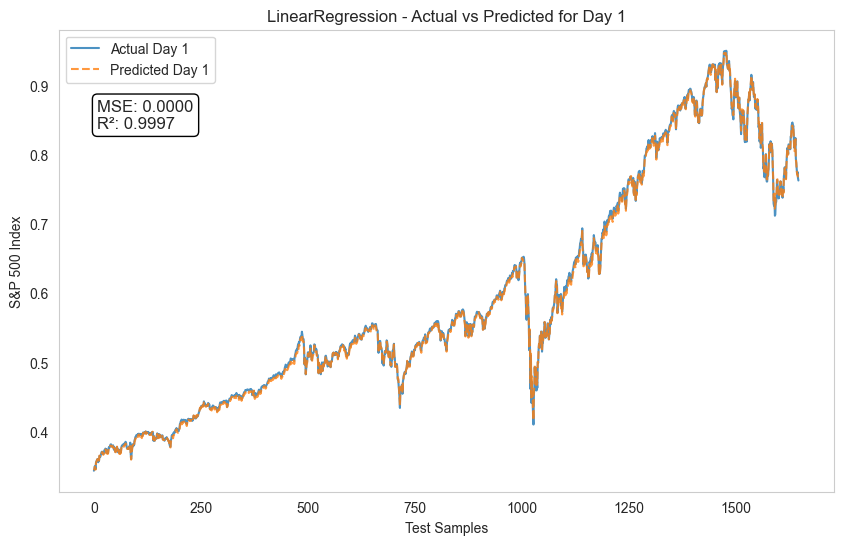

✅ Saved plot: ./plots/training\LinearRegression_day_1.png


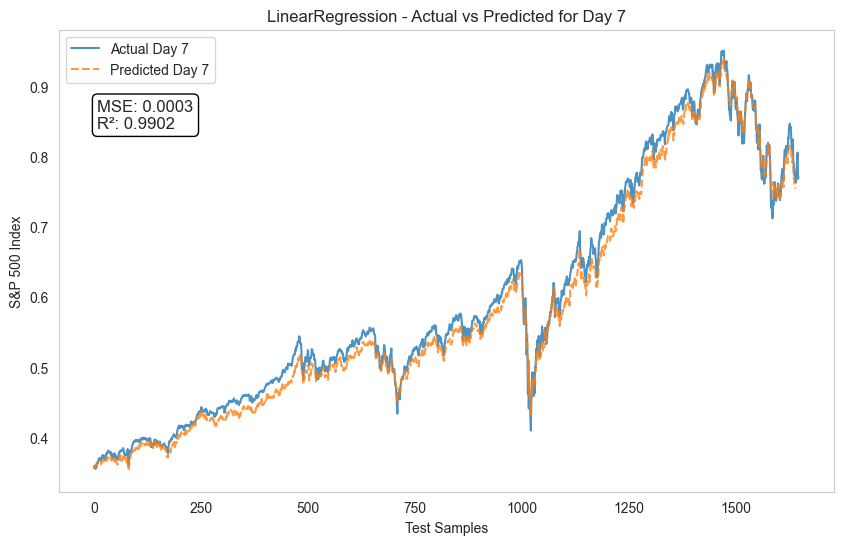

✅ Saved plot: ./plots/training\LinearRegression_day_7.png


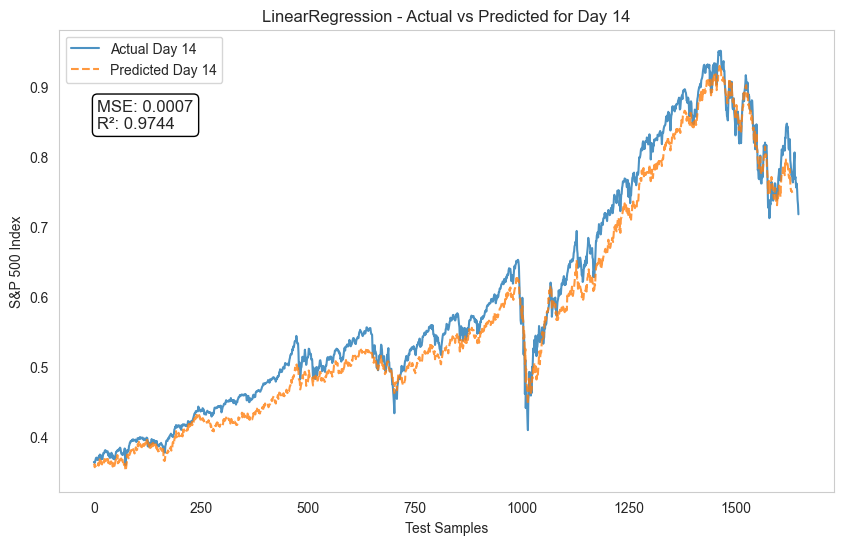

✅ Saved plot: ./plots/training\LinearRegression_day_14.png


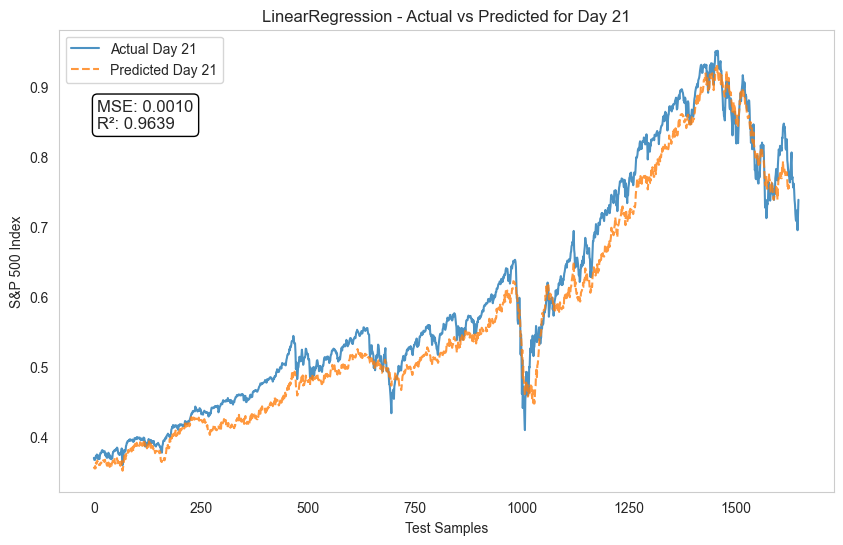

✅ Saved plot: ./plots/training\LinearRegression_day_21.png


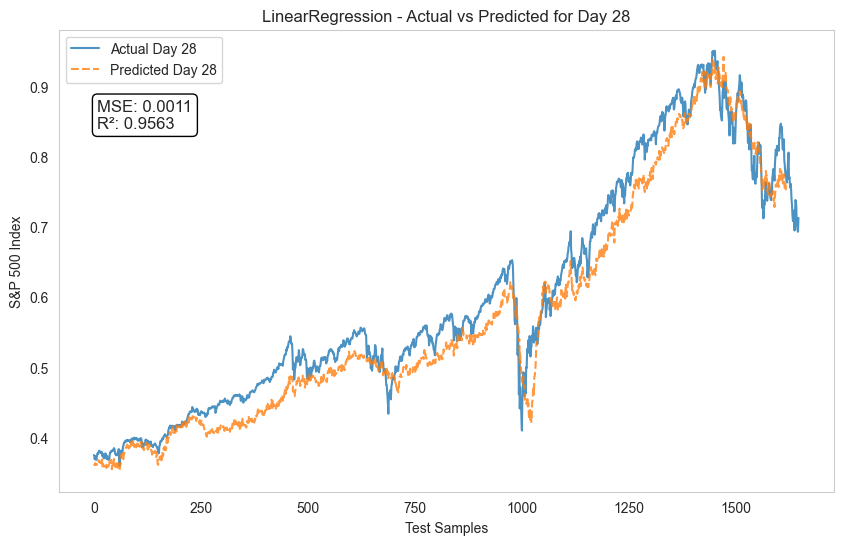

✅ Saved plot: ./plots/training\LinearRegression_day_28.png

Training Ridge with Optimized Parameters...

Training Ridge for target: sp500_next_1...


Training Ridge for target: sp500_next_7...


Training Ridge for target: sp500_next_14...


Training Ridge for target: sp500_next_21...


Training Ridge for target: sp500_next_28...

Ridge - Day 1: MSE=0.0000, R²=0.9995
Ridge - Day 7: MSE=0.0002, R²=0.9907
Ridge - Day 14: MSE=0.0006, R²=0.9762
Ridge - Day 21: MSE=0.0009, R²=0.9652
Ridge - Day 28: MSE=0.0011, R²=0.9593


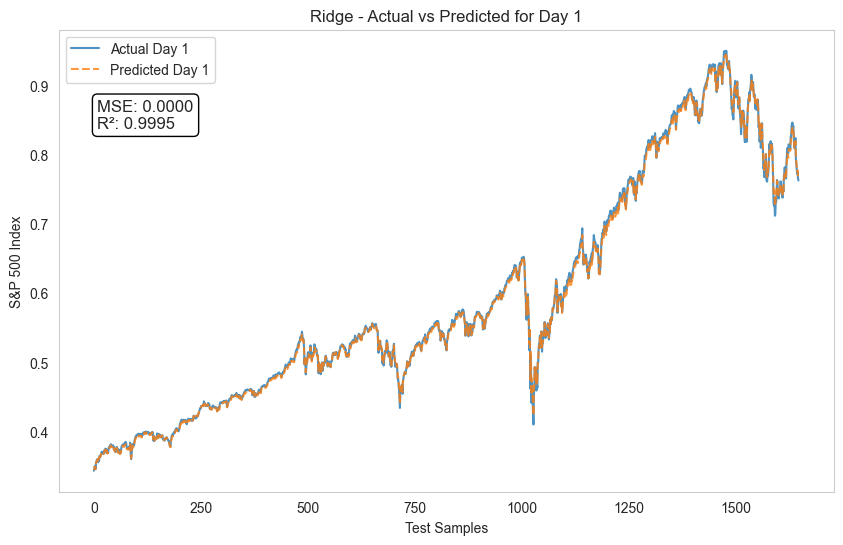

✅ Saved plot: ./plots/training\Ridge_day_1.png


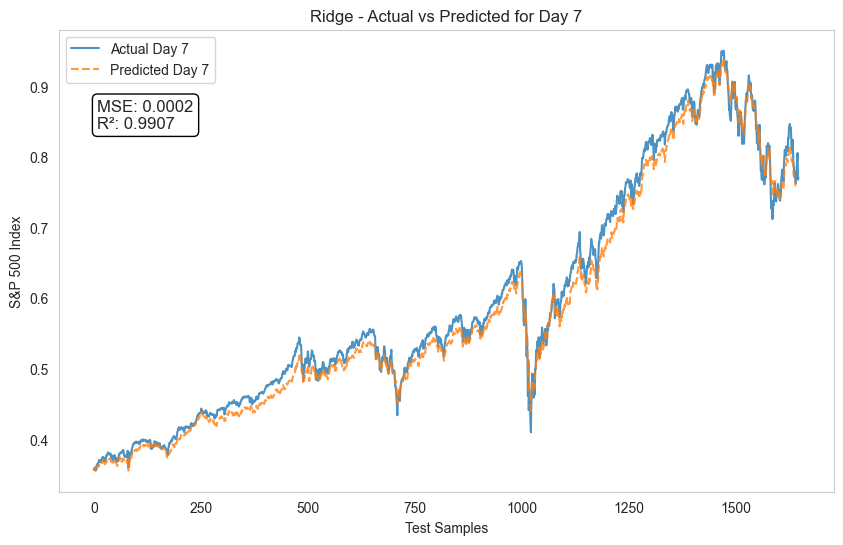

✅ Saved plot: ./plots/training\Ridge_day_7.png


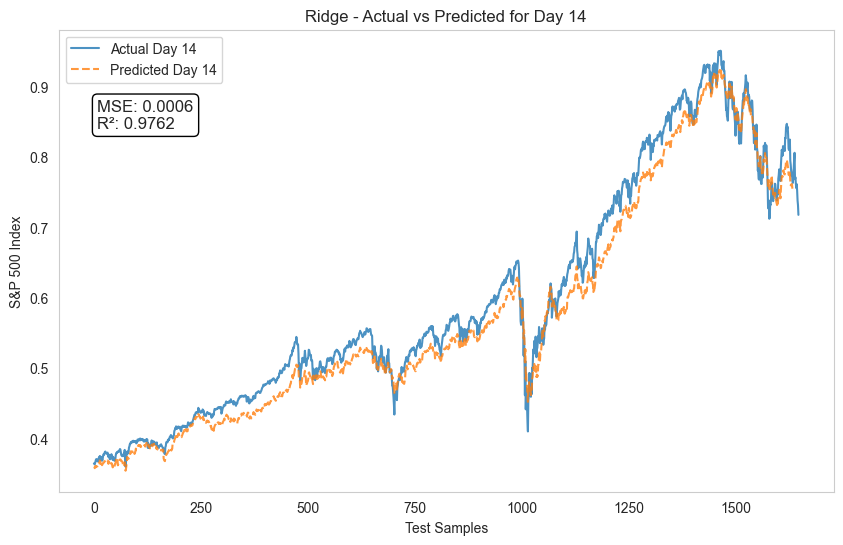

✅ Saved plot: ./plots/training\Ridge_day_14.png


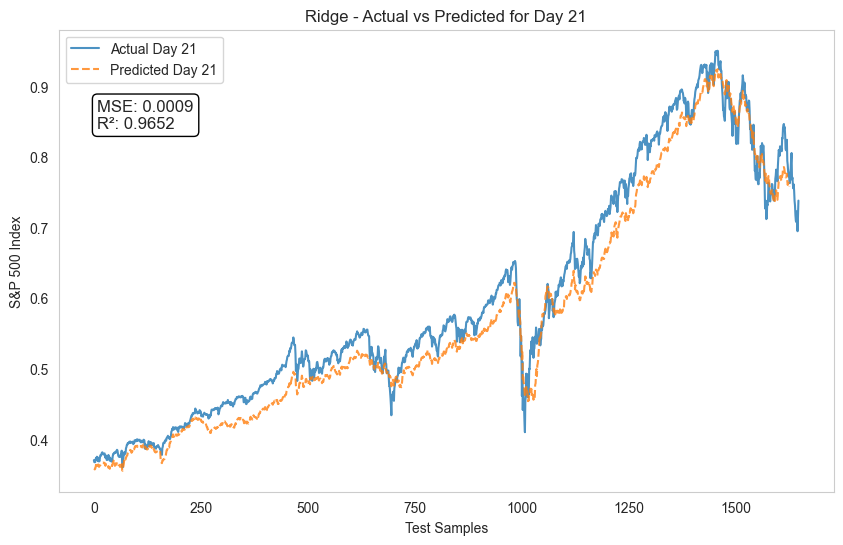

✅ Saved plot: ./plots/training\Ridge_day_21.png


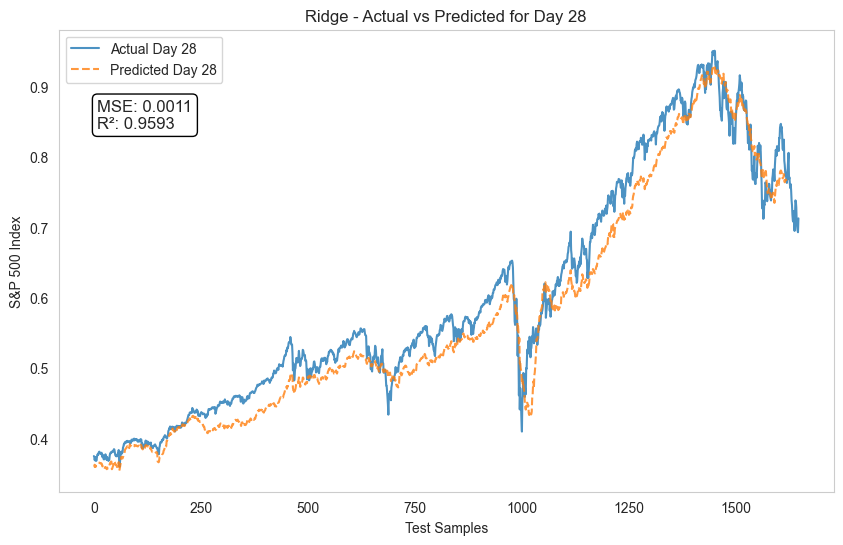

✅ Saved plot: ./plots/training\Ridge_day_28.png

Training SVR with Optimized Parameters...

Training SVR for target: sp500_next_1...


Training SVR for target: sp500_next_7...


Training SVR for target: sp500_next_14...


Training SVR for target: sp500_next_21...


Training SVR for target: sp500_next_28...

SVR - Day 1: MSE=0.0007, R²=0.9745
SVR - Day 7: MSE=0.0006, R²=0.9768
SVR - Day 14: MSE=0.0011, R²=0.9585
SVR - Day 21: MSE=0.0010, R²=0.9624
SVR - Day 28: MSE=0.0014, R²=0.9476


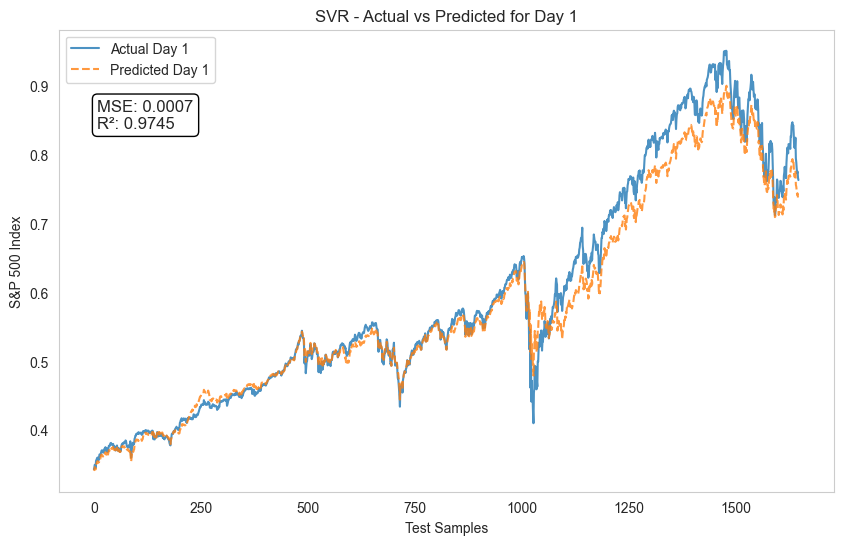

✅ Saved plot: ./plots/training\SVR_day_1.png


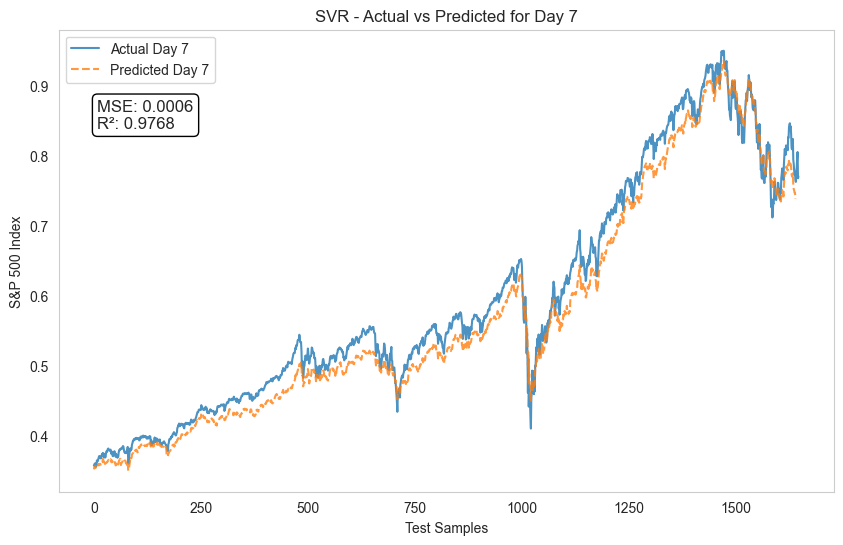

✅ Saved plot: ./plots/training\SVR_day_7.png


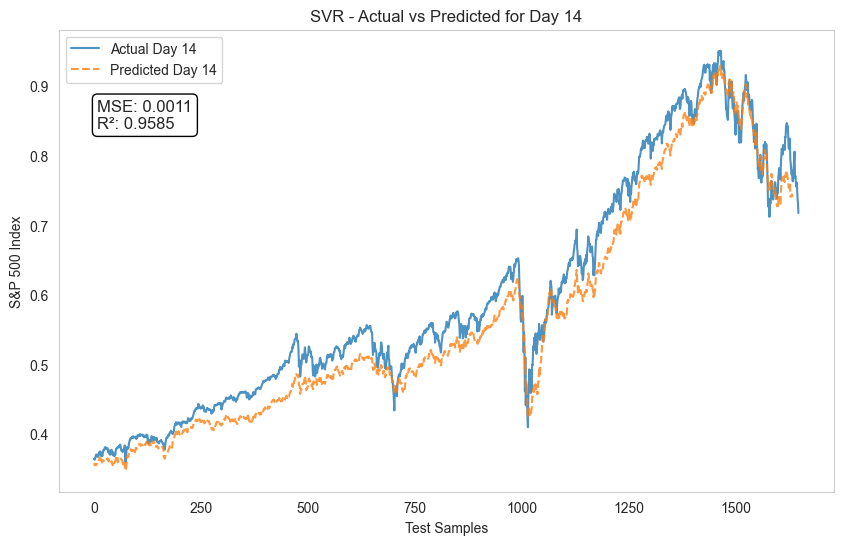

✅ Saved plot: ./plots/training\SVR_day_14.png


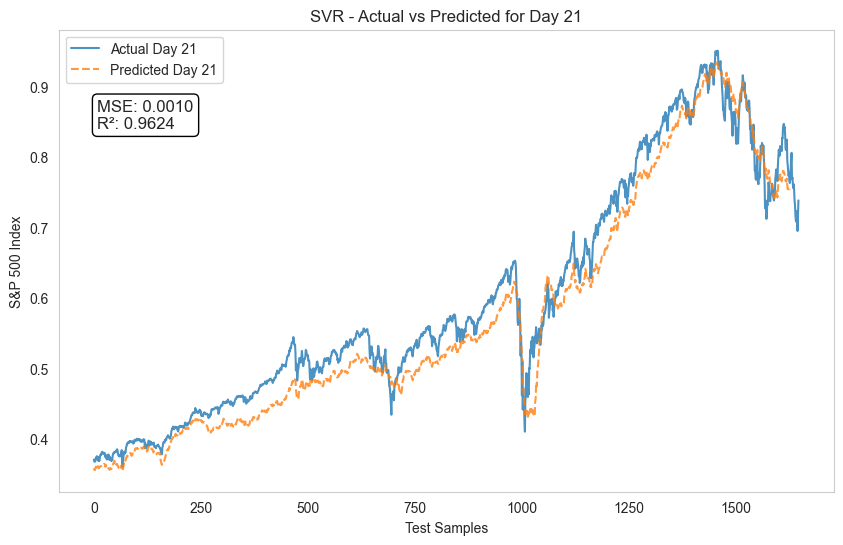

✅ Saved plot: ./plots/training\SVR_day_21.png


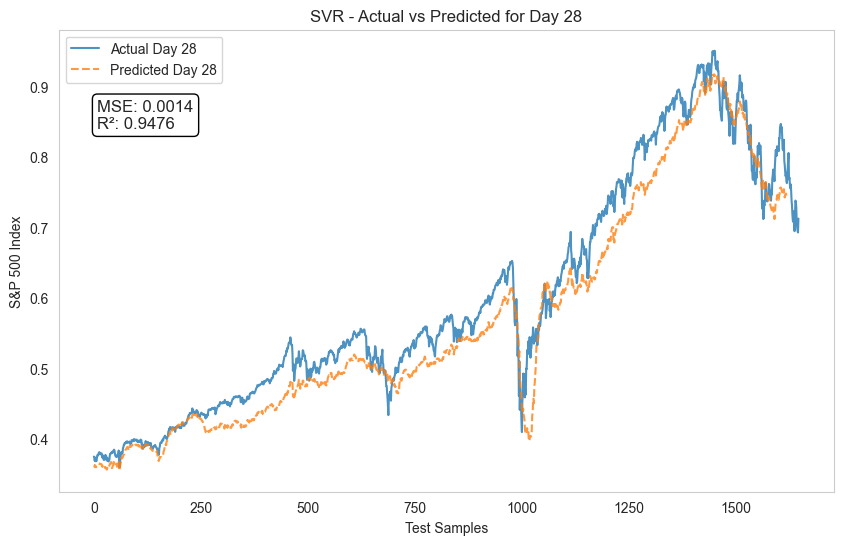

✅ Saved plot: ./plots/training\SVR_day_28.png


In [22]:
# Use best parameters from Optuna
best_ridge_params = study_ridge.best_params
best_svr_params = study_svr.best_params

# Train with best parameters
models = {
    "LinearRegression": {},
    "Ridge": best_ridge_params,
    "SVR": best_svr_params,
}

all_results = {}
for model_name, params in models.items():
    print(f"\nTraining {model_name} with Optimized Parameters...\n" + "=" * 50)

    # Train model
    model, y_pred = train_model(model_name, X_train, y_train, X_test, **params)

    # Evaluate model
    results = evaluate_model(model_name, y_test, y_pred, days_to_predict)

    # Store results
    all_results[model_name] = results

    # Plot predictions
    plot_predictions(y_test, y_pred, days_to_predict, results, model_name)

In [24]:
# Convert the dictionary into a DataFrame for easy visualization
rows = []
for model, results in all_results.items():
    for day, metrics in results.items():
        rows.append([model, day, metrics["MSE"], metrics["R²"]])

df_results = pd.DataFrame(rows, columns=["Model", "Prediction Horizon (Days)", "MSE", "R²"])

# Display the DataFrame
df_results

,Model,Prediction Horizon (Days),MSE,R²
0,LinearRegression,1,0.000008,0.999716
1,LinearRegression,7,0.000261,0.990206
2,LinearRegression,14,0.000679,0.974397
3,LinearRegression,21,0.000952,0.963946
4,LinearRegression,28,0.001149,0.956303
5,Ridge,1,0.000012,0.999545
6,Ridge,7,0.000248,0.990686
7,Ridge,14,0.000630,0.976244
8,Ridge,21,0.000919,0.965204
9,Ridge,28,0.001070,0.959338


# Conclusion and Future Work
...